# Model Prediction

### Stacked Model: XGB + LGBM => Elastic Net Meta Regressor

The best performing model in terms of fit was a stacked ensemble, bearing an R2 score of approximately 0.9125. It is important to restate the results of the learning curves explored for each model -- though the R2 scores are quite high, there model tuning did not affect the overall convergence of each respective algorithm (XGB, LGBM), indicating that more data is needed to both improve the fit, and allow the validation and training errors to converge to a better value.

This section entails benchmarking of the stacked ensemble with regards to prediction time, and final analysis of error metrics for the testing phase.

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso, ElasticNet)
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
import warnings
import os
import timeit
import time
warnings.filterwarnings('ignore')
SEED=42
CV_FOLDS=10
kc_data = pd.read_csv('ci_i5_ap.csv')

In [74]:
import datetime
kc_data = kc_data.drop(['id', 'date'], axis=1)
kc_data.head()
kc_data['price'] = np.log(kc_data['price'])
kc_train, kc_test, train_Y, test_Y = train_test_split(
    kc_data, kc_data['price'], 
    test_size=.25, 
    random_state=SEED
)
kc_train = kc_train.drop('price', axis=1)
kc_test = kc_test.drop('price', axis=1)
scaler = StandardScaler()
kc_train = scaler.fit_transform(kc_train)
kc_test = scaler.transform(kc_test)

In [75]:
from mlxtend.regressor import StackingRegressor
from pylightgbm.models import GBMRegressor
import xgboost as xgb

home = os.path.expanduser("~")
exec = os.path.join(home, "LightGBM/lightgbm")

lgbm = GBMRegressor(exec_path=exec, 
                    boosting_type='gbdt',
                    feature_fraction_seed=SEED,
                    bagging_seed=SEED,
                    tree_learner='serial',
                    metric='r2', #l2
                    verbose=False,
                    
                    num_leaves=35,
                    num_iterations=3800,#350 faster1
                    learning_rate=0.01,#0.1 faster1
                    max_bin=500, #255 faster1

                    min_data_in_leaf=5,
                    feature_fraction=1,

                    bagging_fraction=1,
                    bagging_freq=10,

                    metric_freq=1,
                    early_stopping_round=19
                   )

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [76]:
gbm = xgb.XGBRegressor(
    min_child_weight=5, 
    max_depth=3, 
    objective='reg:linear',
    gamma=0,
    reg_alpha=0.6,
    reg_lambda=1,
    learning_rate=0.1, 
    colsample_bytree=1.0, 
    seed=SEED, 
    n_estimators=2375, 
    subsample=1,
    verbose=True
)

In [77]:
from mlxtend.regressor import StackingRegressor
lin_reg = LinearRegression()
meta_reg_elastic = ElasticNet(alpha=0.0095, l1_ratio=0, tol=0.00001, random_state=SEED)
stacked_reg = StackingRegressor(regressors=[lgbm, gbm], meta_regressor = meta_reg_elastic)

In [91]:
#Construct Dataframes to save results
gbm_df = pd.DataFrame(columns=[['avg_pred', 'single_pred', 'rmse', 'mae', 'logerror']])
lgbm_df = pd.DataFrame(columns=[['avg_pred', 'single_pred', 'rmse', 'mae', 'logerror']])

### Model Fitting and Prediction

In [78]:
stacked_reg.fit(kc_train, train_Y)

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


StackingRegressor(meta_regressor=ElasticNet(alpha=0.0095, copy_X=True, fit_intercept=True, l1_ratio=0,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=42, selection='cyclic', tol=1e-05, warm_start=False),
         regressors=[GBMRegressor(application='regression', bagging_fraction=1, bagging_freq=10,
       bagging_seed=42, boosting_type='gbdt', config='', drop_rate=0.01,
       drop_seed=4, early_stopping_round=19,
       exec_path='/Users/rlong/LightGBM/lightgbm', feature_fraction=1,
       feature_fraction...lpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
       silent=True, subsample=1, verbose=True)],
         verbose=0)

In [79]:
i = 0
ensemble_time = 0

for i in range(num_runs):
    start = time.time()
    stacked_pred = stacked_reg.predict(kc_test)
    end = time.time()
    ensemble_time += end-start


In [162]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

unlog_Y = np.exp(test_Y)
unlog_pred = np.exp(stacked_pred)
log_err = np.sum(np.log(unlog_Y) - np.log(unlog_pred))

ensemble_dict ={
    'name': 'ensemble',
    'avg_pred':(ensemble_time/num_runs * 100000), 
    'single_pred':(ensemble_time/num_runs) / len(test_Y) * 100000, 
    'rmse': math.sqrt(mean_squared_error(unlog_Y, unlog_pred)),
    'mae': mean_absolute_error(unlog_Y, unlog_pred),
    'log_error': log_err
}
ensemble_dict

{'avg_pred': 175007.98439979553,
 'log_error': 8.5659487050232066,
 'mae': 60042.760940711058,
 'name': 'ensemble',
 'rmse': 108324.62334558432,
 'single_pred': 32.38489718723085}

In [127]:
print("GBM Avg Predict Time(μs): ", ensemble_dict['avg_pred'])
print("GBM Single Predict Time (μs): ", ensemble_dict['single_pred'])
print("Ensemble RMSE: ", ensemble_dict['rmse'])
print("Ensemble MAE: ", ensemble_dict['mae'])
print("Ensemble Log Lerror: ", ensemble_dict['log_error'])

GBM Avg Predict Time(μs):  175007.98439979553
GBM Single Predict Time (μs):  32.38489718723085
Ensemble RMSE:  108324.62334558432
Ensemble MAE:  60042.7609407
Ensemble Log Lerror:  8.56594870502


In [64]:
home = os.path.expanduser("~")
exec = os.path.join(home, "LightGBM/lightgbm")

lgbm_alone = GBMRegressor(exec_path=exec, 
                    boosting_type='gbdt',
                    feature_fraction_seed=SEED,
                    bagging_seed=SEED,
                    tree_learner='serial',
                    metric='r2', #l2
                    verbose=False,
                    
                    num_leaves=35,
                    num_iterations=3800,#350 faster1
                    learning_rate=0.01,#0.1 faster1
                    max_bin=500, #255 faster1

                    min_data_in_leaf=5,
                    feature_fraction=1,

                    bagging_fraction=1,
                    bagging_freq=10,

                    metric_freq=1,
                    early_stopping_round=19
                   )

pyLightGBM is looking for 'LIGHTGBM_EXEC' environment variable, cannot be found.
exec_path will be deprecated in favor of environment variable


In [67]:
lgbm_alone.fit(kc_train, train_Y)
i = 0
lgbm_time = 0
num_runs = 100
for i in range(num_runs):
    start = time.time()
    lgbm_pred = lgbm_alone.predict(kc_test)
    end = time.time()
    lgbm_time += end-start


In [161]:
unlog_lgbm_pred = np.exp(lgbm_pred)

lgbm_dict ={
    'name': 'lgbm',
    'avg_pred':(lgbm_time/num_runs * 100000), 
    'single_pred':(lgbm_time/num_runs) / len(test_Y) * 100000, 
    'rmse': math.sqrt(mean_squared_error(unlog_Y, unlog_lgbm_pred)),
    'mae': mean_absolute_error(unlog_Y, unlog_lgbm_pred),
    'log_error': np.sum(np.log(unlog_Y) - np.log(unlog_lgbm_pred))
}

print("LGBM Avg Predict Time (μs): ", lgbm_dict['avg_pred'])
print("LGBM Single Predict Time (μs): ", lgbm_dict['single_pred'])
print("LGBM RMSE: ", lgbm_dict['rmse'])
print("LGBM MAE: ", lgbm_dict['mae'])
print("LGBM Log-Error ", lgbm_dict['log_error'])

LGBM Avg Predict Time (μs):  138332.80515670776
LGBM Single Predict Time (μs):  25.59822449235895
LGBM RMSE:  110317.53265051449
LGBM MAE:  61356.4845731
LGBM Log-Error  15.7727686688


In [33]:
gbm_alone = xgb.XGBRegressor(
    min_child_weight=5, 
    max_depth=3, 
    objective='reg:linear',
    gamma=0,
    reg_alpha=0.6,
    reg_lambda=1,
    learning_rate=0.1, 
    colsample_bytree=1.0, 
    seed=SEED, 
    n_estimators=2375, 
    subsample=1,
    verbose=True
)

In [35]:
gbm_alone.fit(kc_train, train_Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=2375,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.6, reg_lambda=1, scale_pos_weight=1, seed=42,
       silent=True, subsample=1, verbose=True)

In [69]:
i = 0
gbm_time = 0

for i in range(num_runs):
    start = time.time()
    gbm_pred = gbm_alone.predict(kc_test)
    end = time.time()
    gbm_time += end-start
    


In [160]:
unlog_gbm_pred = np.exp(lgbm_pred)
gbm_dict ={
    'name': 'GBM',
    'avg_pred':(gbm_time/num_runs * 100000), 
    'single_pred':(gbm_time/num_runs) / len(test_Y) * 100000, 
    'rmse': math.sqrt(mean_squared_error(unlog_Y, unlog_gbm_pred)),
    'mae': mean_absolute_error(unlog_Y, unlog_gbm_pred),
    'log_error': np.sum(np.log(unlog_Y) - np.log(unlog_gbm_pred))
}

print("GBM Avg Predict Time(μs): ", gbm_dict['avg_pred'])
print("GBM Single Predict Time (μs): ", gbm_dict['single_pred'])
print("GBM RMSE: ", gbm_dict['rmse'])
print("GBM MAE: ", gbm_dict['mae'])
print("GBM Log-Error: ", gbm_dict['log_error'])

GBM Avg Predict Time(μs):  37479.17318344116
GBM Single Predict Time (μs):  6.935450256003175
GBM RMSE:  110317.53265051449
GBM MAE:  61356.4845731
GBM Log-Error:  15.7727686688


# Analysis of Performance Results

In [163]:
df = pd.DataFrame(ensemble_dict, index=[0])
df = df.append(lgbm_dict, ignore_index=True)
df = df.append(gbm_dict, ignore_index=True)

In [164]:
df

,avg_pred,log_error,mae,name,rmse,single_pred
0,175007.984400,8.565949,60042.760941,ensemble,108324.623346,32.384897
1,138332.805157,15.772769,61356.484573,lgbm,110317.532651,25.598224
2,37479.173183,15.772769,61356.484573,GBM,110317.532651,6.935450


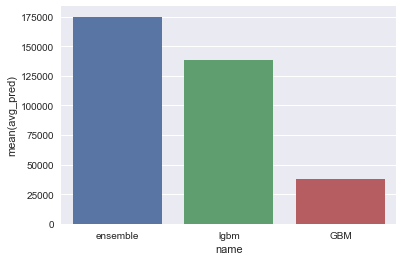

In [169]:
sns.barplot(x='name', y='avg_pred', data=df)

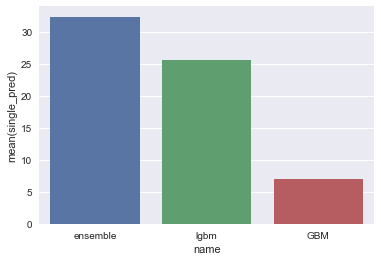

In [170]:
sns.barplot(x='name', y='single_pred', data=df)

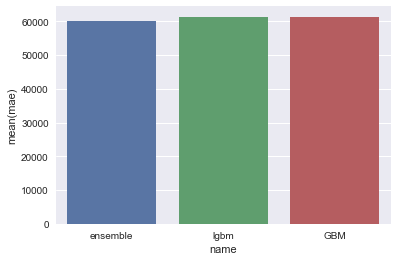

In [171]:
sns.barplot(x='name', y='mae', data=df)

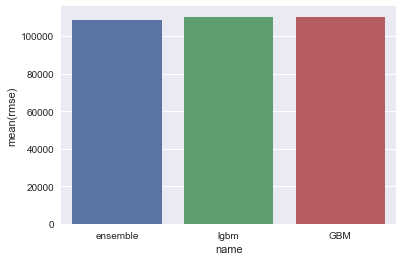

In [172]:
sns.barplot(x='name', y='rmse', data=df)

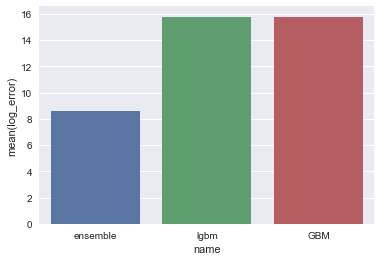

In [173]:
sns.barplot(x='name', y='log_error', data=df)

The overall RMSE and MAE scores of each respective models are relatively comparable, with the RMSE of the ensemble being slightly more efficient (approximately 1,000 dollars less). There is a tradeoff to be considered, in which the ensemble takes the most time (approximately the duration of the LGBM + GBM prediction times), but overall performs better on error metrics, especially as it faces a significant reduction in log loss error, from 16 down to 8.5. 

GBM seems to be the most lightweight of the model, only requiring 7 microseconds per prediction. It is important to consider the run-time use-cases for each model, if one is constructing a customer-facing api that utilizes one of these models for predictions. These prediction times are only relative -- though the stacked ensemble is the slowest, it is still relatively quick in the span of predicting, requiring only 32 microseconds per prediction. Additionally, if speed remains a problem, stacked ensembling allows distributed processing by fitting and predicting on different machines for a parallel approach.

There remains an extensive amount of tuning and feature engineering available to improving the predictive capabilities of this model set, but these approaches were constrained due to cost and time. Additionally, the models need more data in order to converge further to an optimal result. Possible additional features were explored in the feature engineering section, which culminates in further leveraging the lat, long features in regards to coast distances, and overall proximity to amenities for a neighborhood rating. 